In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

In [2]:
import cv2

In [3]:
FTRAIN = "/images/params.csv"

In [4]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
print(tf.__version__)
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.95
#config.gpu_options.visible_device_list = "0"
#### 1 GPU1
#### 2 GPU2
#### 0 GPU3
#### 4 GPU4
#set_session(tf.Session(config=config))

1.15.0


Using TensorFlow backend.


In [5]:
input_height, input_width = 400, 400

In [6]:
def get_image(fname):
    img = cv2.imread(fname, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_GRAYSCALE)
    #if img is None:
    #     return None
    img = cv2.resize(img, (input_width, input_height))
    img = img[np.newaxis, :]
    return img

In [7]:
def NormalizeData(data):
    return (data - np.min(data)) / float(np.max(data) - np.min(data))

In [8]:
def plot_sample(X,y,axs):
    '''
    kaggle picture is 96 by 96
    y is rescaled to range between -1 and 1
    '''
    
    axs.imshow(X.reshape(input_width,input_height),cmap="gray")
    axs.scatter((input_width//2)*y[0::2]+ (input_width//2),(input_height//2)*y[1::2]+ (input_height//2))
    
def load(cols=None):
    """
    load test/train data
    cols : a list containing landmark label names.
           If this is specified, only the subset of the landmark labels are 
           extracted. for example, cols could be:
           
          [left_eye_center_x, left_eye_center_y]
            
    return: 
    X: 2-d numpy array (Nsample, Ncol*Nrow)
    y: 2-d numpy array (Nsample, Nlandmarks*2) 
       In total there are 15 landmarks. 
       As x and y coordinates are recorded, u.shape = (Nsample,30)
       
    """

    fname = FTRAIN
    df = read_csv(os.path.expanduser(fname)) 

    
    #df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    df['Image'] = df['id_string'].apply(lambda im: get_image('/images/all_images/' + im + '.tif'))
    del df['id_string']

    if cols:  
        df = df[list(cols) + ['Image']]

    myprint = df.count()
    myprint = myprint.reset_index()
    print(myprint)  
    ## row with at least one NA columns are removed!
    df = df.dropna()  
    

    #X = np.vstack(df['Image'].values) / 255.  # changes valeus between 0 and 1
    #X = np.vstack(df['Image'].values) / 65535.  # changes valeus between 0 and 1
    X = NormalizeData(np.vstack(df['Image'].values))
    X = X.astype(np.float32)

    ## standardization of the response
    y = df[df.columns[:-1]].values
    #y = (y - 48) / 48  # y values are between [-1,1]
    y = (y - 0.5) * 2
    X, y = shuffle(X, y, random_state=42)  # shuffle data
    y = y.astype(np.float32)
    
    
    return X, y

def load2d(cols=None):

    re = load(cols)
    
    X = re[0].reshape(-1,input_width,input_height,1)
    y = re[1]

    return X, y

def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*(input_height//2) 
        val_loss = np.sqrt(np.array(val_loss))*(input_height//2) 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

In [9]:
## load data
X, y = load2d()
X.shape

         index     0
0      red_0_x  1387
1      red_0_y  1387
2      red_1_x  1387
3      red_1_y  1387
4      red_2_x  1387
..         ...   ...
124  blue_30_x  1387
125  blue_30_y  1387
126  blue_31_x  1387
127  blue_31_y  1387
128      Image  1387

[129 rows x 2 columns]


(1387, 400, 400, 1)

In [10]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

from keras import regularizers

from keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout

#l2 = regularizers.l2(0.01)

def SimpleCNN():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(input_width,input_height, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(128))
    
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return(model)

In [11]:
%%time
model2 = SimpleCNN()

model2.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 398, 398, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 199, 199, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 197, 197, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
______________________________________

In [12]:


hist2 = model2.fit(X,y,nb_epoch=300,validation_split=0.2,verbose=True, epochs=50, batch_size=32)

C:\Users\Usrer\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.



Train on 1109 samples, validate on 278 samples
Epoch 1/300
1109/1109 [==============================] - 17s 15ms/step - loss: 0.0293 - accuracy: 0.2444 - val_loss: 0.0043 - val_accuracy: 0.9245
Epoch 2/300
1109/1109 [==============================] - 9s 8ms/step - loss: 0.0070 - accuracy: 0.3968 - val_loss: 0.0022 - val_accuracy: 0.6691
Epoch 3/300
1109/1109 [==============================] - 9s 8ms/step - loss: 0.0046 - accuracy: 0.4310 - val_loss: 0.0027 - val_accuracy: 0.8273
Epoch 4/300
1109/1109 [==============================] - 9s 8ms/step - loss: 0.0036 - accuracy: 0.4527 - val_loss: 0.0011 - val_accuracy: 0.8957
Epoch 5/300
1109/1109 [==============================] - 9s 8ms/step - loss: 0.0028 - accuracy: 0.4932 - val_loss: 0.0011 - val_accuracy: 0.7986
Epoch 6/300
1109/1109 [==============================] - 9s 8ms/step - loss: 0.0027 - accuracy: 0.4941 - val_loss: 8.6027e-04 - val_accuracy: 0.9137
Epoch 7/300
1109/1109 [==============================] - 9s 8ms/step - loss:

Epoch 54/300
1109/1109 [==============================] - 9s 8ms/step - loss: 8.7276e-04 - accuracy: 0.7529 - val_loss: 3.4002e-04 - val_accuracy: 0.9209
Epoch 55/300
1109/1109 [==============================] - 9s 8ms/step - loss: 8.2401e-04 - accuracy: 0.7800 - val_loss: 3.6755e-04 - val_accuracy: 0.9209
Epoch 56/300
1109/1109 [==============================] - 9s 8ms/step - loss: 8.5274e-04 - accuracy: 0.7701 - val_loss: 3.6721e-04 - val_accuracy: 0.9245
Epoch 57/300
1109/1109 [==============================] - 9s 8ms/step - loss: 7.9633e-04 - accuracy: 0.7367 - val_loss: 3.2009e-04 - val_accuracy: 0.9209
Epoch 58/300
1109/1109 [==============================] - 9s 8ms/step - loss: 9.0234e-04 - accuracy: 0.7511 - val_loss: 3.7012e-04 - val_accuracy: 0.9101
Epoch 59/300
1109/1109 [==============================] - 9s 8ms/step - loss: 8.3070e-04 - accuracy: 0.7746 - val_loss: 3.0632e-04 - val_accuracy: 0.9245
Epoch 60/300
1109/1109 [==============================] - 9s 8ms/step - loss

1109/1109 [==============================] - 9s 8ms/step - loss: 7.2700e-04 - accuracy: 0.8530 - val_loss: 3.9813e-04 - val_accuracy: 0.9209
Epoch 108/300
1109/1109 [==============================] - 9s 8ms/step - loss: 7.4192e-04 - accuracy: 0.8476 - val_loss: 3.2522e-04 - val_accuracy: 0.9245
Epoch 109/300
1109/1109 [==============================] - 9s 8ms/step - loss: 7.3363e-04 - accuracy: 0.8449 - val_loss: 3.8640e-04 - val_accuracy: 0.9245
Epoch 110/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.8019e-04 - accuracy: 0.8494 - val_loss: 3.3904e-04 - val_accuracy: 0.9137
Epoch 111/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.7337e-04 - accuracy: 0.8539 - val_loss: 3.5970e-04 - val_accuracy: 0.9209
Epoch 112/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.8891e-04 - accuracy: 0.8485 - val_loss: 3.3941e-04 - val_accuracy: 0.9209
Epoch 113/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.797

Epoch 160/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.2872e-04 - accuracy: 0.8936 - val_loss: 2.8618e-04 - val_accuracy: 0.9173
Epoch 161/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.4744e-04 - accuracy: 0.8864 - val_loss: 3.0818e-04 - val_accuracy: 0.9245
Epoch 162/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.4916e-04 - accuracy: 0.8891 - val_loss: 3.8724e-04 - val_accuracy: 0.9173
Epoch 163/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.6271e-04 - accuracy: 0.8945 - val_loss: 3.0009e-04 - val_accuracy: 0.9209
Epoch 164/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.6137e-04 - accuracy: 0.8882 - val_loss: 3.7596e-04 - val_accuracy: 0.9209
Epoch 165/300
1109/1109 [==============================] - 9s 8ms/step - loss: 7.2587e-04 - accuracy: 0.8900 - val_loss: 3.3417e-04 - val_accuracy: 0.9209
Epoch 166/300
1109/1109 [==============================] - 9s 8ms/step

Epoch 213/300
1109/1109 [==============================] - 9s 8ms/step - loss: 5.8303e-04 - accuracy: 0.8900 - val_loss: 2.4093e-04 - val_accuracy: 0.9209
Epoch 214/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.2676e-04 - accuracy: 0.8972 - val_loss: 2.7138e-04 - val_accuracy: 0.9173
Epoch 215/300
1109/1109 [==============================] - 9s 8ms/step - loss: 5.9988e-04 - accuracy: 0.8972 - val_loss: 2.7439e-04 - val_accuracy: 0.9209
Epoch 216/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.1471e-04 - accuracy: 0.8963 - val_loss: 2.6611e-04 - val_accuracy: 0.9209
Epoch 217/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.2387e-04 - accuracy: 0.8963 - val_loss: 2.9015e-04 - val_accuracy: 0.9245
Epoch 218/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.1957e-04 - accuracy: 0.8945 - val_loss: 2.5043e-04 - val_accuracy: 0.9209
Epoch 219/300
1109/1109 [==============================] - 9s 8ms/step

Epoch 266/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.3321e-04 - accuracy: 0.8954 - val_loss: 2.7346e-04 - val_accuracy: 0.9209
Epoch 267/300
1109/1109 [==============================] - 9s 8ms/step - loss: 5.8026e-04 - accuracy: 0.8990 - val_loss: 2.6621e-04 - val_accuracy: 0.9173
Epoch 268/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.3110e-04 - accuracy: 0.8945 - val_loss: 2.9196e-04 - val_accuracy: 0.9173
Epoch 269/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.2255e-04 - accuracy: 0.8999 - val_loss: 3.0596e-04 - val_accuracy: 0.9173
Epoch 270/300
1109/1109 [==============================] - 9s 8ms/step - loss: 6.1571e-04 - accuracy: 0.8936 - val_loss: 2.5978e-04 - val_accuracy: 0.9173
Epoch 271/300
1109/1109 [==============================] - 9s 8ms/step - loss: 5.8360e-04 - accuracy: 0.8972 - val_loss: 2.8091e-04 - val_accuracy: 0.9173
Epoch 272/300
1109/1109 [==============================] - 9s 8ms/step

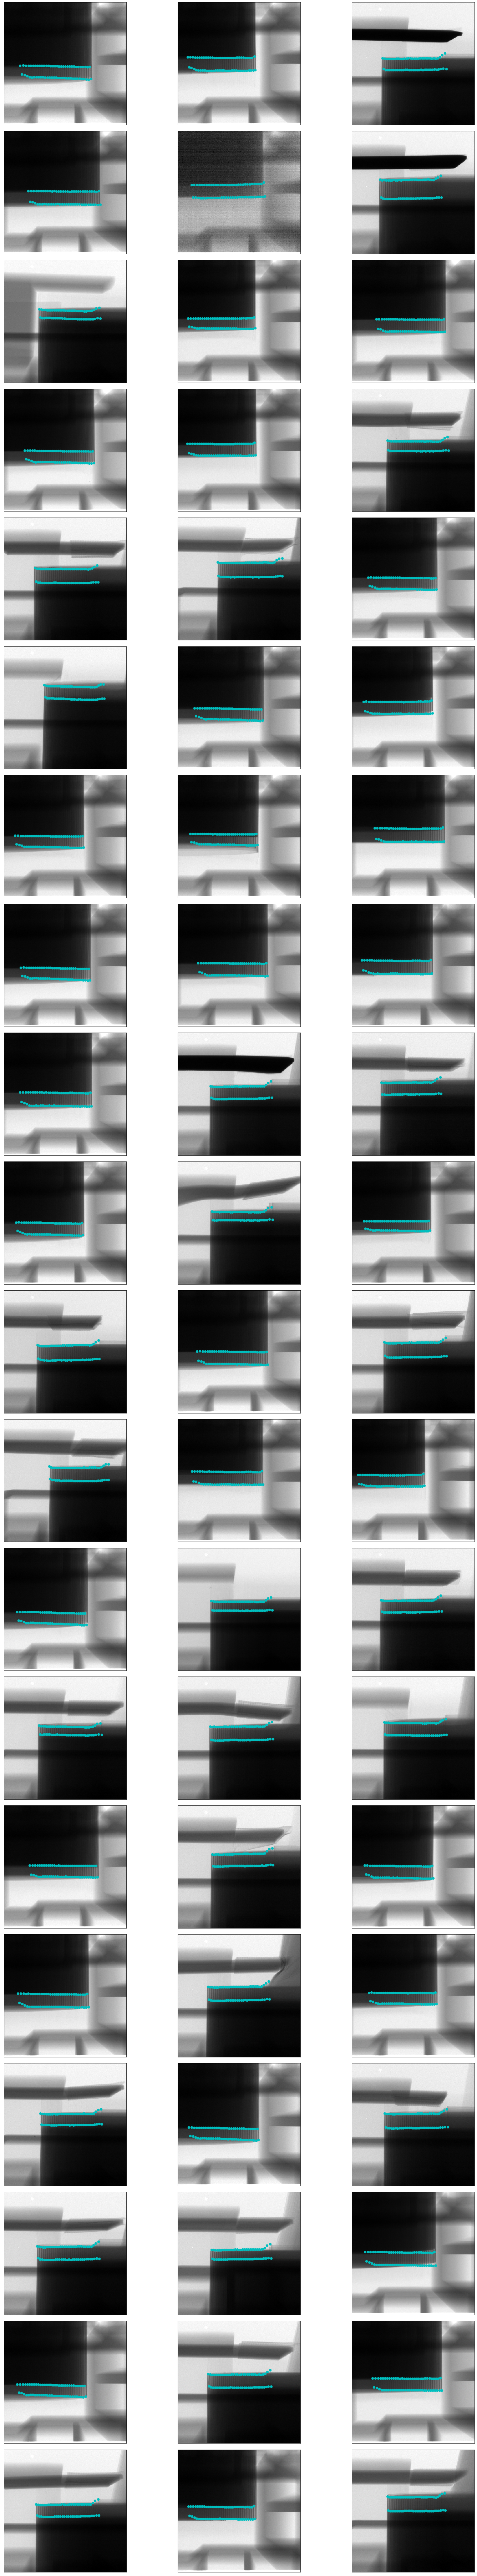

In [20]:
def plot_data(img, landmarks, axis):
    """
    Plot image (img), along with normalized facial keypoints (landmarks)
    """
    axis.imshow(np.squeeze(img), cmap='gray') # plot the image
    landmarks = landmarks * 200 + 200 # undo the normalization
    # Plot the keypoints
    axis.scatter(landmarks[0::2],
        landmarks[1::2],
        marker='o',
        c='c',
        s=40)


y_test = model2.predict(X)
fig = plt.figure(figsize=(20,100))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(60):
    ax = fig.add_subplot(20, 3, i + 1, xticks=[], yticks=[])
    plot_data(X[i], y_test[i], ax)